# prep

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import scipy.io as sio
from tqdm import tqdm
import os
import pickle
%load_ext autoreload
%autoreload 2

In [2]:
local_flag = False
if local_flag:
    repo_dir = r'D:\repo\inter_data\inter'.replace("\\", "/") # under env dimred
else:
    repo_dir = r'C:\Users\ll357\Documents\inter'.replace("\\", "/")
os.chdir(repo_dir)
from src import adp

# batch write df_tidy
rewrite all grat SF data, from me or lindsey, to bin SF to SF_ref

In [3]:
SF_ref = np.logspace(1, 6, num=6, base=2)/100
SF_ref

array([0.02, 0.04, 0.08, 0.16, 0.32, 0.64])

In [30]:
mode = 'map to ref SF'

mat_inter_path = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter/'.replace('\\', '/')
meta = pd.read_excel(mat_inter_path + 'adp_dataset_master.xlsx')
meta = meta[(meta.paradigm == 'grat_SF_lindsey') | (meta.paradigm == 'grat_SF6')]
meta = meta[~meta.note.str.contains('bad', na=False)] # exclude bad sessions
meta['date_sess'] = meta.date.astype(str) + '_00' + meta.num.astype(str)
meta

for date_sess in meta.date_sess.unique(): # date-sess combo is unique. loop over sessions, not dates, to account for multi sessions on same day # edit: actually, df_tidy is built from trace_trial_stim.mat, which already merged multisess. so loop over dates is fine too
    print(date_sess)
    
    mouse_now = meta[meta.date_sess == date_sess].mouse.unique()[0].astype(str)
    date_now = meta[meta.date_sess == date_sess].date.unique()[0].astype(str)
    sess_now = '00' + meta[meta.date_sess == date_sess].num.unique()[0].astype(str)
    paradigm_now = meta[meta.date_sess == date_sess].paradigm.unique()[0]
    print(mouse_now, date_now, sess_now, paradigm_now)
    
    ## load data
    dir_data = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter/'
    if paradigm_now == 'grat_SF_lindsey':
        dir_data += f'V1_i{mouse_now}_{date_now}_lindsey'
    elif paradigm_now == 'grat_SF6':
        dir_data += f'V1_i{mouse_now}_{date_now}_cellpose'    
    stim_id, trace_by_trial = adp.load_trace_trial_data(os.path.join(dir_data), vis_filter=False)
    if np.min(stim_id[0]) == 1: # stim id was 1-based index
        stim_id[0] -= 1 # stim id adjusted to 0-based index
    assert np.min(stim_id[0]) == 0

    base1 = trace_by_trial[:,:,0:2+1].mean(axis=2) # avg over time window frames
    resp_ad = trace_by_trial[:,:,9:11+1].mean(axis=2)
    resp_ad = resp_ad - base1
    base2 = trace_by_trial[:,:,13:14+1].mean(axis=2)
    resp_tg = trace_by_trial[:,:,20:22+1].mean(axis=2)
    resp_tg = resp_tg - base2

    ## merge SF
    if paradigm_now == 'grat_SF_lindsey':
        dir_data_now = os.path.join(
            r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lindsey\Analysis\2P/'.replace("\\", "/"),
            str(date_now) + r'_i' + str(mouse_now),
            str(date_now) + r'_i' + str(mouse_now) + r'_runs-' + str(2).zfill(3) # only sess 002 is usable from lindsey's data
        )
        input_mworks = [file for file in os.listdir(dir_data_now) if file.endswith("_input.mat")][0]
        input_mworks = sio.loadmat(os.path.join(dir_data_now, input_mworks))
        SF_cpd = input_mworks['input']['tStimOneGratingSpatialFreqCPD'][0][0][0]
        SF_flat = np.array([SF_cpd[i][0][0] for i in range(len(SF_cpd))])
        SF_now = np.unique(SF_flat)

    elif paradigm_now == 'grat_SF6':
        dir_data_now = os.path.join(
            r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Analysis\2P/'.replace("\\", "/"),
            date_now + r'_i' + mouse_now,
            date_now + r'_i' + mouse_now + r'_runs-' + sess_now
        )
        input_mworks = [file for file in os.listdir(dir_data_now) if file.endswith("_input.mat")][0]
        input_mworks = sio.loadmat(os.path.join(dir_data_now, input_mworks))
        SF_cpd = input_mworks['behav_input']['tStimOneGratingSpatialFreqCPD'][0][0][0]
        SF_flat = np.array([SF_cpd[i][0][0] for i in range(len(SF_cpd))])
        SF_now = np.unique(SF_flat)
    
    ## map stim_id to ref stim_id
    print(np.round(SF_ref, 2))
    stim_dict = {}
    for (iSF, SF_cpd) in enumerate(SF_now):
        print(iSF, np.round(SF_cpd, 2), np.argmin(np.abs(SF_ref - SF_cpd)))
        stim_dict[iSF] = np.argmin(np.abs(SF_ref - SF_cpd))
    # print(stim_dict) # key: current data's stim_id, value: mapped to ref stim_id
    stim_id_mapped = np.array([stim_dict[i] for i in stim_id[0]])

    ## df tidy
    R1_dfof = resp_ad.flatten() # cell x trial, row major flatten
    R2_dfof = resp_tg.flatten()
    dfof = np.hstack((R1_dfof, R2_dfof))

    ncell = resp_ad.shape[0]
    ntrial = resp_ad.shape[1]
    cell_id = np.repeat(np.arange(ncell), ntrial)
    cell_id = np.hstack((cell_id, cell_id)) # stack two copies for R1 and R2

    trial_id = np.tile(np.arange(ntrial), ncell)
    trial_id = np.hstack((trial_id, trial_id))

    print(f'{mode} mode')
    if mode == 'map to ref SF':
        stim_id_col = np.tile(stim_id_mapped, ncell)
        stim_id_ori = np.tile(stim_id[0], ncell)
        stim_id_ori = np.hstack((stim_id_ori, stim_id_ori)) # keep record of original stim_id in lindsey's data, to match img_driven (filter_cell_stim)
    else:
        stim_id_col = np.tile(stim_id[0], ncell)
    stim_id_col = np.hstack((stim_id_col, stim_id_col))

    len_df = ncell * ntrial * 2 # 2 for (R1, R2)
    resp_id = ['R1'] * (len_df//2) + ['R2'] * (len_df//2) # first half is flattened resp_ad, second half is flattened resp_tg

    df_tidy = pd.DataFrame({'dfof': dfof, 'cell_id': cell_id, 'trial_id': trial_id, 'stim_id': stim_id_col, 'resp_id': resp_id})
    if mode == 'map to ref SF':
        df_tidy['stim_id_ori'] = stim_id_ori

    ## trial filter
    trial_filter_file = [f for f in os.listdir(dir_data) if f.__contains__('filter_trials_')]

    trial_ok = np.array([])
    for file in trial_filter_file:
        trial_filter = sio.loadmat(os.path.join(dir_data, file))
        trial_eye_ok = trial_filter['trial_eye_ok']
        trial_eye_ok = np.array([i[0] for i in trial_eye_ok], dtype=bool)
        trial_speed_ok = trial_filter['trial_speed_ok']
        trial_speed_ok = np.array([i[0] for i in trial_speed_ok], dtype=bool)
        trial_ok_sess = trial_eye_ok & trial_speed_ok
        trial_ok_sess = trial_ok_sess[:-1] # remove the last trial, which is not a full trial
        trial_ok = np.append(trial_ok, trial_ok_sess)

    trial_ok = np.array(trial_ok, dtype=bool)
    assert len(trial_ok) == trace_by_trial.shape[1]

    filter_trial = np.tile(trial_ok, ncell)
    filter_trial = np.hstack((filter_trial, filter_trial))
    df_tidy['filter_trial'] = filter_trial

    ## cell filter
    df_tidy['filter_cell'] = np.nan
    df_tidy['filter_cell_stim'] = np.nan

    with open(os.path.join(dir_data, 'vis_driven.pickle'), 'rb') as f:
        filter_file = pickle.load(f)
    filter_cell_stim = filter_file['img_driven']
    filter_cell = filter_file['vis_driven']

    print(f'ncell = {filter_cell_stim.shape[0]}, nstim = {filter_cell_stim.shape[1]}')
    for icell in np.arange(filter_cell_stim.shape[0]):
        df_tidy.loc[df_tidy['cell_id']==icell, 'filter_cell'] = filter_cell[icell][0] # filter_cell is a list of list
        for istim in np.arange(filter_cell_stim.shape[1]):
            df_tidy.loc[(df_tidy['stim_id_ori']==istim) & (df_tidy['cell_id']==icell), 'filter_cell_stim'] = filter_cell_stim[icell, istim]
    
    df_tidy.to_csv(os.path.join(dir_data, 'df_tidy_ref_SF_yuansi.csv'), index=False)
    print('------------')
    # break

230103_002
1375 230103 002 grat_SF6
ncell: 91, nstim: 6, ntrial: 1012, nframe: 197
[0.02 0.04 0.08 0.16 0.32 0.64]
0 0.06 1
1 0.11 2
2 0.19 3
3 0.34 4
4 0.6 5
5 1.08 5
map to ref SF mode
ncell = 91, nstim = 6
------------
230103_003
1375 230103 003 grat_SF6
ncell: 91, nstim: 6, ntrial: 1012, nframe: 197
[0.02 0.04 0.08 0.16 0.32 0.64]
0 0.06 1
1 0.11 2
2 0.19 3
3 0.34 4
4 0.6 5
5 1.08 5
map to ref SF mode
ncell = 91, nstim = 6
------------
230127_003
1380 230127 003 grat_SF6
ncell: 103, nstim: 6, ntrial: 1641, nframe: 197
[0.02 0.04 0.08 0.16 0.32 0.64]
0 0.06 1
1 0.11 2
2 0.19 3
3 0.34 4
4 0.6 5
5 1.08 5
map to ref SF mode
ncell = 103, nstim = 6
------------
230127_004
1380 230127 004 grat_SF6
ncell: 103, nstim: 6, ntrial: 1641, nframe: 197
[0.02 0.04 0.08 0.16 0.32 0.64]
0 0.06 1
1 0.11 2
2 0.19 3
3 0.34 4
4 0.6 5
5 1.08 5
map to ref SF mode
ncell = 103, nstim = 6
------------
230127_005
1380 230127 005 grat_SF6
ncell: 103, nstim: 6, ntrial: 1641, nframe: 197
[0.02 0.04 0.08 0.16 0.3

# batch load df_tidy
across mouse, date, session

In [32]:
date_unique = meta.date.unique()
df_tidy = pd.DataFrame()

for idate in date_unique: # df_tidy is built from trace_trial_stim.mat, which already merged multisess. so loop over dates is fine
    data_meta_sess = meta[meta.date == idate]
    print(f'{idate}: {len(data_meta_sess)} sessions')

    mouse = meta[meta.date == idate].mouse.unique()[0]
    print(f'mouse {mouse}, depth {data_meta_sess.depth.unique()[0]}')

    dir_data = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter/'

    try:
        dir_exp = dir_data + f'V1_i{mouse}_{idate}_cellpose'
        # df_tidy_date = pd.read_csv(os.path.join(dir_exp, 'df_tidy.csv'))
        df_tidy_date = pd.read_csv(os.path.join(dir_exp, 'df_tidy_ref_SF_yuansi.csv'))
    except:
        dir_exp = dir_data + f'V1_i{mouse}_{idate}_lindsey'
        df_tidy_date = pd.read_csv(os.path.join(dir_exp, 'df_tidy_ref_SF_yuansi.csv'))

    df_tidy_date['mouse'] = mouse
    df_tidy_date['date'] = idate
    df_tidy_date['cell_id'] = df_tidy_date.date * 1000 + df_tidy_date.cell_id # cell_id adjusted to be unique across mice and dates. we know ncell < 1000 for each mouse and date
    df_tidy = pd.concat([df_tidy, df_tidy_date], axis=0).reset_index(drop=True)

230103: 2 sessions
mouse 1375, depth 150.0
230127: 3 sessions
mouse 1380, depth 150.0
230209: 3 sessions
mouse 1375, depth 200.0
230214: 3 sessions
mouse 1373, depth 150.0
220526: 1 sessions
mouse 1369, depth nan
220529: 1 sessions
mouse 1372, depth nan
220530: 1 sessions
mouse 1370, depth nan
220619: 1 sessions
mouse 1369, depth nan
220620: 1 sessions
mouse 1370, depth nan
220623: 1 sessions
mouse 1372, depth nan


# batch save merged df_tidy

In [34]:
df_tidy.sample(10)

df_tidy.to_csv(os.path.join(mat_inter_path, 'df_tidy_ref_SF_yuansi_merged.csv'), index=False)

# cell SNR filter (deprecated)

In [35]:
snr_cell_arr = np.array([])

for icell in tqdm(df_tidy.cell_id.unique()):
    df_cell = df_tidy[(df_tidy.cell_id == icell) & (df_tidy.resp_id == 'R1')] # only calc R1 SNR
    signal = df_cell.groupby(['stim_id'])['dfof'].mean()
    noise = df_cell.groupby(['stim_id'])['dfof'].std()
    snr = signal / noise # single cell snr of each stim
    snr_cell = np.median(snr) # median snr across all stims
    snr_cell_arr = np.append(snr_cell_arr, snr_cell)

snr_thres = np.percentile(snr_cell_arr, 50)
print(f'snr_thres: {snr_thres:.2f}')

plt.hist(snr_cell_arr, bins=50);
plt.axvline(snr_thres, color='r', linestyle='--');

 24%|██▍       | 348/1450 [00:53<02:51,  6.44it/s]

In [ ]:
df_tidy['filter_cell_snr'] = False
for (icell, cell_id) in enumerate(df_tidy.cell_id.unique()):
    snr_cell = snr_cell_arr[icell]
    if snr_cell >= snr_thres:
        df_tidy.loc[df_tidy.cell_id == cell_id, 'filter_cell_snr'] = True

try:
    import math
    assert math.isclose(0.5, df_tidy.filter_cell_snr.sum() / len(df_tidy), abs_tol=0.01)
except:
    print(df_tidy.filter_cell_snr.sum() / len(df_tidy))

df_tidy

0.5127193760545525


,dfof,cell_id,trial_id,stim_id,resp_id,filter_trial,filter_cell,filter_cell_stim,mouse,date,stim_id_ori,filter_cell_snr
0,-0.133319,230103000,0,4,R1,True,True,False,1375,230103,NaN,True
1,0.113303,230103000,1,2,R1,True,True,True,1375,230103,NaN,True
2,-0.018100,230103000,2,2,R1,True,True,True,1375,230103,NaN,True
3,-0.032178,230103000,3,3,R1,True,True,True,1375,230103,NaN,True
4,-0.065120,230103000,4,2,R1,True,True,True,1375,230103,NaN,True
...,...,...,...,...,...,...,...,...,...,...,...,...
3088983,-0.023467,220623119,640,0,R2,True,True,False,1372,220623,1.0,False
3088984,0.015559,220623119,641,3,R2,False,True,False,1372,220623,8.0,False
3088985,-0.109568,220623119,642,0,R2,False,True,False,1372,220623,3.0,False
3088986,-0.038351,220623119,643,3,R2,False,True,False,1372,220623,8.0,False


# tidy data filtered 
discarded invalid trial and cell x stim combo

In [ ]:
df_filter = df_tidy[df_tidy['filter_cell'] # vis driven filter
                    # & df_tidy['filter_cell_stim'] # img driven filter
                    # & df_tidy['filter_cell_snr'] # snr filter
                    # & df_tidy['filter_trial']
                    ]
df_filter

,dfof,cell_id,trial_id,stim_id,resp_id,stim_id_ori,filter_trial,filter_cell,filter_cell_stim,mouse,date
0,-0.133319,230103000,0,5,R1,4,True,True,False,1375,230103
1,0.113303,230103000,1,3,R1,2,True,True,True,1375,230103
2,-0.018100,230103000,2,3,R1,2,True,True,True,1375,230103
3,-0.032178,230103000,3,4,R1,3,True,True,True,1375,230103
4,-0.065120,230103000,4,3,R1,2,True,True,True,1375,230103
...,...,...,...,...,...,...,...,...,...,...,...
3088983,-0.023467,220623119,640,1,R2,1,True,True,False,1372,220623
3088984,0.015559,220623119,641,4,R2,8,False,True,False,1372,220623
3088985,-0.109568,220623119,642,2,R2,3,False,True,False,1372,220623
3088986,-0.038351,220623119,643,4,R2,8,False,True,False,1372,220623


# adaptation vs SF

## construct filter_pref

In [233]:
df_pref = df_filter.copy()
df_pref['filter_pref'] = False

# for each cell, find the stim with the largest resp
for icell in df_filter.cell_id.unique():
    df_cell = df_pref[df_pref['cell_id']==icell]
    df_cell = df_cell[df_cell['resp_id']=='R1'] # only use R1
    if len(df_cell) == 0:
        continue
    df_cell = df_cell.groupby(['stim_id'])['dfof'].mean().reset_index() # mean dfof of each stim
    df_cell = df_cell.sort_values(by='dfof', ascending=False) # sort by dfof, largest first
    pref_stim = df_cell.iloc[0]['stim_id'].astype(int) # stim id of the largest resp
    df_pref.loc[(df_pref['cell_id']==icell) & (df_pref['stim_id']==pref_stim), 'filter_pref'] = True
df_pref

,dfof,cell_id,trial_id,stim_id,resp_id,stim_id_ori,filter_trial,filter_cell,filter_cell_stim,mouse,date,filter_pref
0,-0.133319,230103000,0,5,R1,4,True,True,False,1375,230103,False
1,0.113303,230103000,1,3,R1,2,True,True,True,1375,230103,True
2,-0.018100,230103000,2,3,R1,2,True,True,True,1375,230103,True
3,-0.032178,230103000,3,4,R1,3,True,True,True,1375,230103,False
4,-0.065120,230103000,4,3,R1,2,True,True,True,1375,230103,True
...,...,...,...,...,...,...,...,...,...,...,...,...
3088983,-0.023467,220623119,640,1,R2,1,True,True,False,1372,220623,False
3088984,0.015559,220623119,641,4,R2,8,False,True,False,1372,220623,False
3088985,-0.109568,220623119,642,2,R2,3,False,True,False,1372,220623,False
3088986,-0.038351,220623119,643,4,R2,8,False,True,False,1372,220623,False


### tuning curve of neurons with diff SF pref

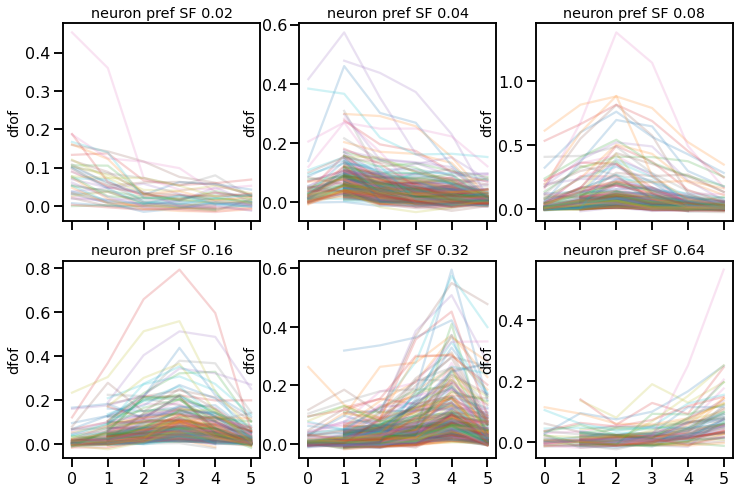

In [273]:
nstim = len(df_pref.stim_id.unique())
fig, ax = plt.subplots(nrows=2, ncols=nstim//2, figsize=(12, 8), sharex=True) # , sharey=True
# for each stim, draw on a subplot

for istim in sorted(df_pref.stim_id.unique()):
    # get cells who prefer this stim
    df_pref_istim = df_pref[(df_pref.stim_id == istim) & (df_pref.filter_pref == True)]

    for icell in df_pref_istim.cell_id.unique():
    # for icell in df_pref_istim.cell_id.sample(50, random_state=42).unique():
        df_pref_icell = df_pref[df_pref.cell_id == icell]
        stim_arr = df_pref_icell.groupby(['stim_id'])['dfof'].mean().index.values
        resp_arr = df_pref_icell.groupby(['stim_id'])['dfof'].mean().values

        ax[istim//3, istim%3].plot(stim_arr, resp_arr, alpha=0.2)
        SF_ref = np.logspace(1, 6, num=6, base=2) / 100 # 0.02-0.64 cpd
        ax[istim//3, istim%3].set_title(f'neuron pref SF {SF_ref[istim]}')
        ax[istim//3, istim%3].set_xticks(stim_arr)
        ax[istim//3, istim%3].set_ylabel('dfof')
        # break
    # break

## apply pref filter

In [ ]:
df_pref = df_pref[df_pref['filter_pref']] # only retain preferred stim x cell combo

### can change SF range
check if cells preferring extreme SF still is responsive to middle SF -> decide if change grat6SF cpd parameters

In [32]:
extreme_pref = df_pref[
                    (df_pref.stim_id == df_pref.stim_id.min()) | 
                    (df_pref.stim_id == df_pref.stim_id.max()) | # highest SF was discarded in final adp-SF plot anyway
                    (df_pref.stim_id == df_pref.stim_id.max() - 1) # so maybe we care about the 2nd highest SF
                     ].sort_values(by='stim_id')
extreme_pref_cell = extreme_pref.cell_id.unique() # cells who prefer extreme SF

tmp = df_tidy[df_tidy.cell_id.isin(extreme_pref_cell)]
stim_id_not_extreme = np.sort(df_tidy.stim_id.unique())[1:-1]
tmp = tmp[tmp.stim_id.isin(stim_id_not_extreme)] # are they responsive to non-extreme SF?
tmp = tmp.groupby('stim_id')['filter_cell_stim'].sum() / tmp.groupby('stim_id')['filter_cell_stim'].count() # proportion of cells who prefer extreme SF AND responsive to each non-extreme SF
print(tmp)

print('we can still change SF param, since some cells who prefer extreme SF are responsive to less-extreme SF')

stim_id
1    0.318733
2    0.314724
3    0.340618
Name: filter_cell_stim, dtype: float64
we can still change SF param, since cells who prefer extreme SF are responsive to less-extreme SF


## boot adp for pop

(array([-0.16735524, -0.00888563,  0.01168425,  0.28641548, -0.01239941,
        -0.01939625, -0.02384969,  0.03656092, -0.06868829]),
 0.2864154813504123)

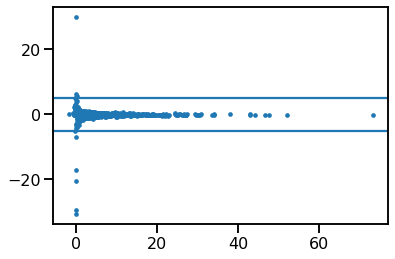

In [149]:
# nboot = 100
# nrep_selected = 30 # dictated by grat1 adp stability test
# seed_arr = np.random.randint(0, 100, size=nboot) # get random seed for each bootstrap
# iboot = 0
# R1_agg = (df_pref[(df_pref['resp_id']=='R1')]
#                 .groupby(['stim_id', 'cell_id'])['dfof']
#                 .apply(lambda x: x.sample(n=nrep_selected, replace=True, 
#                                             random_state=seed_arr[iboot]) # select same trial reps for R1 and R2
#                 .sum())
#                 .reset_index()['dfof'].values) # for each stim x cell, randomly select nrep trials resp, take sum
# R2_agg = (df_pref[(df_pref['resp_id']=='R2')]
#                 .groupby(['stim_id', 'cell_id'])['dfof']
#                 .apply(lambda x: x.sample(n=nrep_selected, replace=True, 
#                                             random_state=seed_arr[iboot])
#                 .sum())
#                 .reset_index()['dfof'].values)
# adp_agg = (R2_agg - R1_agg) / (R2_agg + R1_agg + 1e-7)
# plt.scatter(R2_agg + R1_agg, adp_agg, s=10)
# plt.axhline(-5)
# plt.axhline(5);
# # plt.xlim(-2, 2);

# R_sum = R2_agg + R1_agg
# R_sum[np.abs(adp_agg)>5], R_sum[np.abs(adp_agg)>5].max()

In [200]:
# output should be of shape: nboot x nstim x ncell
# for each bootstrap, for each stim x cell, randomly select nrep trials

nboot = 100
nrep_selected = 30 # dictated by grat1 adp stability test
seed_arr = np.random.randint(0, 100, size=nboot) # get random seed for each bootstrap

R1_boot = []
R2_boot = []
adp_boot = []
for iboot in tqdm(np.arange(nboot)):
    R1_agg = (df_pref[(df_pref['resp_id']=='R1')]
                    .groupby(['stim_id', 'cell_id'])['dfof']
                    .apply(lambda x: x.sample(n=nrep_selected, replace=True, 
                                              random_state=seed_arr[iboot]) # select same trial reps for R1 and R2
                    .mean())
                    .reset_index()['dfof'].values) # for each stim x cell, randomly select nrep trials resp, take sum
    R2_agg = (df_pref[(df_pref['resp_id']=='R2')]
                    .groupby(['stim_id', 'cell_id'])['dfof']
                    .apply(lambda x: x.sample(n=nrep_selected, replace=True, 
                                              random_state=seed_arr[iboot])
                    .mean())
                    .reset_index()['dfof'].values)
    adp_agg = (R2_agg - R1_agg) / (R2_agg + R1_agg + 1e-7) # IOU version
    # adp_agg = (R2_agg - R1_agg) / (R1_agg + 1e-7) # diff over R1 version
    R1_agg[np.abs(adp_agg) > 5] = np.nan
    adp_agg[np.abs(adp_agg) > 5] = np.nan # remove outliers
    # adp_agg[np.abs(R2_agg + R1_agg) < 0.1] = np.nan # remove outliers

    R1_boot.append(R1_agg)
    R2_boot.append(R2_agg)
    adp_boot.append(adp_agg)
print('adp hard thresholding')
# print('using adp as diff, not ratio')

R1_boot = np.array(R1_boot)
R2_boot = np.array(R2_boot)
adp_boot = np.array(adp_boot)

100%|██████████| 100/100 [01:39<00:00,  1.01it/s]

adp hard thresholding


In [201]:
# adp_boot shape = nboot x (nstim x ncell, preferred)

df_adp_pref = (df_pref[(df_pref['resp_id']=='R1')]
                .groupby(['stim_id', 'cell_id'])['dfof']
                .apply(lambda x: x.sample(n=nrep_selected, replace=True).sum()) # dfof col was not used
                .reset_index())

# agg_method = np.nanmedian
agg_method = np.nanmean
R1_boot_agg = agg_method(R1_boot, axis=0)
R2_boot_agg = agg_method(R2_boot, axis=0)
adp_boot_agg = agg_method(adp_boot, axis=0) # sum over all bootstraps
df_adp_pref['R1_pref'] = R1_boot_agg
df_adp_pref['R2_pref'] = R2_boot_agg
df_adp_pref['adp_pref'] = adp_boot_agg

df_adp_pref = df_adp_pref.dropna(subset=['adp_pref']) # remove nan, which is adp outliers
df_adp_pref.tail(), df_adp_pref.shape, df_adp_pref.stim_id.max()

(      stim_id    cell_id      dfof   R1_pref   R2_pref  adp_pref
 1330        5  230103011  0.342666  0.031612  0.028959 -0.052692
 1331        5  230127005  0.333303  0.044527  0.025607  0.043771
 1332        5  230127030  0.230276  0.027684  0.036445  0.156095
 1333        5  230127037  0.977228  0.021851  0.043592  0.245028
 1334        5  230127053  1.740110  0.064049  0.039964 -0.261251,
 (1335, 6),
 5)

### boxplot across cells
for each SF, take cells that prefer this grating SF. boxplot errorbar is across cells

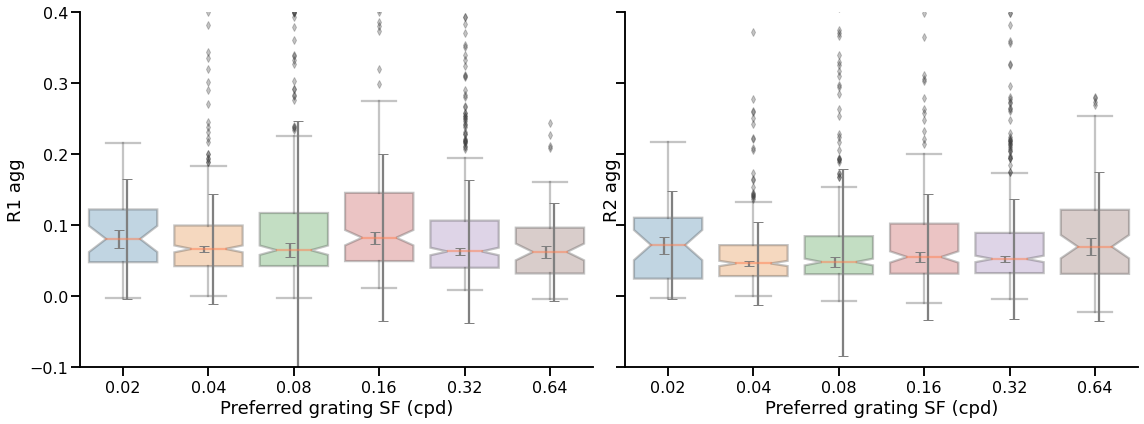

In [275]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6), sharex=True, sharey=True)

sns.boxplot(x='stim_id', y='R1_pref', data=df_adp_pref, ax=ax[0], 
            notch=True, 
            boxprops=dict(alpha=.3), 
            whiskerprops=dict(alpha=.3),
            capprops=dict(alpha=.3),
            flierprops=dict(alpha=.3),
            medianprops={"color": "coral", "alpha": .5},
            meanprops={"color": "orange"},)

adp_pref_agg = df_adp_pref.groupby('stim_id')['R1_pref'].median().values
adp_pref_std = df_adp_pref.groupby('stim_id')['R1_pref'].std().values
adp_pref_sem = df_adp_pref.groupby('stim_id')['R1_pref'].sem().values
ax[0].errorbar(np.arange(adp_pref_agg.shape[0])+0.05, adp_pref_agg,
            yerr=adp_pref_std, fmt='none', color='gray', capsize=5)
ax[0].errorbar(np.arange(adp_pref_agg.shape[0])-0.05, adp_pref_agg,
            yerr=adp_pref_sem, fmt='none', color='gray', capsize=5)

ax[0].set_xlabel('Preferred grating SF (cpd)', fontsize=18)
SF_ref = np.logspace(1, 6, num=6, base=2)/100 # 0.02-0.64 cpd. this should be updated to match # batch rewrite df tidy
cpd_array = np.round(SF_ref, 2) #[:-1] # discard highest SF, due to no cell prefer it
try:
    ax[0].set_xticklabels(cpd_array)
except:
    ax[0].set_xticklabels(cpd_array[:-1])
ax[0].set_ylabel('R1 agg', fontsize=18)
ax[0].set_ylim([-0.1, 0.4])
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)


sns.boxplot(x='stim_id', y='R2_pref', data=df_adp_pref, ax=ax[1], 
            notch=True, 
            boxprops=dict(alpha=.3), 
            whiskerprops=dict(alpha=.3),
            capprops=dict(alpha=.3),
            flierprops=dict(alpha=.3),
            medianprops={"color": "coral", "alpha": .5},
            meanprops={"color": "orange"},)

adp_pref_agg = df_adp_pref.groupby('stim_id')['R2_pref'].median().values
adp_pref_std = df_adp_pref.groupby('stim_id')['R2_pref'].std().values
adp_pref_sem = df_adp_pref.groupby('stim_id')['R2_pref'].sem().values
ax[1].errorbar(np.arange(adp_pref_agg.shape[0])+0.05, adp_pref_agg,
            yerr=adp_pref_std, fmt='none', color='gray', capsize=5)
ax[1].errorbar(np.arange(adp_pref_agg.shape[0])-0.05, adp_pref_agg,
            yerr=adp_pref_sem, fmt='none', color='gray', capsize=5)

ax[1].set_xlabel('Preferred grating SF (cpd)', fontsize=18)
SF_ref = np.logspace(1, 6, num=6, base=2)/100 # 0.02-0.64 cpd. this should be updated to match # batch rewrite df tidy
cpd_array = np.round(SF_ref, 2) #[:-1] # discard highest SF, due to no cell prefer it
try:
    ax[1].set_xticklabels(cpd_array)
except:
    ax[1].set_xticklabels(cpd_array[:-1])
ax[1].set_ylabel('R2 agg', fontsize=18)
# ax[1].set_ylim([-0.1, 0.4])
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)

fig.tight_layout()

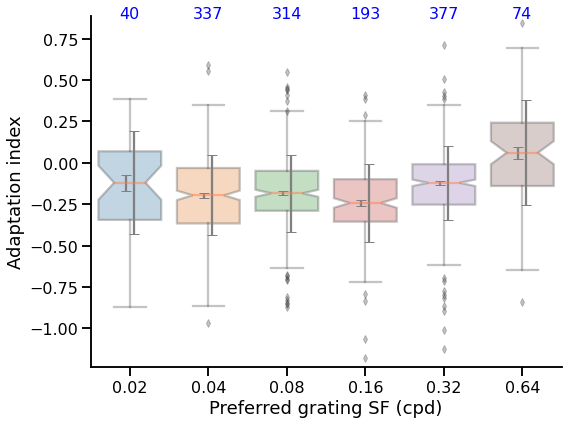

In [232]:
# for each stim_id, plot adp_pref for each cell in a boxplot

# df_adp_pref = df_adp_pref[df_adp_pref.stim_id < 5] # discard highest SF, due to no cell prefer it

fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(x='stim_id', y='adp_pref', data=df_adp_pref, ax=ax, 
            notch=True, 
            boxprops=dict(alpha=.3), 
            whiskerprops=dict(alpha=.3),
            capprops=dict(alpha=.3),
            flierprops=dict(alpha=.3),
            medianprops={"color": "coral", "alpha": .5},
            meanprops={"color": "orange"},)
# sns.swarmplot(x='stim_id', y='adp_pref', data=df_adp_pref, ax=ax, alpha=0.5)

adp_pref_agg = df_adp_pref.groupby('stim_id')['adp_pref'].median().values
adp_pref_std = df_adp_pref.groupby('stim_id')['adp_pref'].std().values
adp_pref_sem = df_adp_pref.groupby('stim_id')['adp_pref'].sem().values

# ax.plot(np.arange(adp_pref_agg.shape[0])-0.05, adp_pref_agg, 
#         'gray', marker='o', markersize=7, linewidth=1)
ax.errorbar(np.arange(adp_pref_agg.shape[0])+0.05, adp_pref_agg,
            yerr=adp_pref_std, fmt='none', color='gray', capsize=5)
ax.errorbar(np.arange(adp_pref_agg.shape[0])-0.05, adp_pref_agg,
            yerr=adp_pref_sem, fmt='none', color='gray', capsize=5)

# add text at each xtick
ncell_SF = df_adp_pref.groupby('stim_id')['cell_id'].nunique().values # ncell for each stim_id
for i, ncell_iSF in enumerate(ncell_SF):
    ncell_iSF = int(ncell_iSF)
    # ax.text(i, -1.3, ncell_iSF, ha='center', va='center', fontsize=16, color='blue')
    ax.text(i, 0.9, ncell_iSF, ha='center', va='center', fontsize=16, color='blue')

ax.set_xlabel('Preferred grating SF (cpd)', fontsize=18)
SF_ref = np.logspace(1, 6, num=6, base=2)/100 # 0.02-0.64 cpd. this should be updated to match # batch rewrite df tidy
# SF_ref = np.logspace(2, 6, num=5, base=2)/100 # 0.04-0.64 cpd. this should be updated to match # batch rewrite df tidy
cpd_array = np.round(SF_ref, 2) #[:-1] # discard highest SF, due to no cell prefer it
try:
    ax.set_xticklabels(cpd_array)
except:
    ax.set_xticklabels(cpd_array[:-1])
    # assert df_adp_pref.stim_id.max() == 4 # there is no stim_id 5 (highest SF) left after adp thres
ax.set_ylabel('Adaptation index', fontsize=18)
# ax.set_ylim([-2, 1])
ax.set_ylim([np.nanmin(df_adp_pref['adp_pref'].values * 1.05), np.nanmax(df_adp_pref['adp_pref'].values * 1.05)])

# turn off upper and right spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

fig.tight_layout()
dir_fig = r'C:\Users\ll357\Documents\inter\results\joint lab meeting 2023-03'.replace('\\', '/')
# fig.savefig(os.path.join(dir_fig, 'adp_pref_grat_SF6_diff_over_R1.pdf'), bbox_inches='tight')

C:\Users\ll357\AppData\Local\Temp\7\ipykernel_56984\1260459573.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  axx.set_xticklabels(['0','0.02', '0.04', '0.08', '0.16', '0.32', '0.64']);


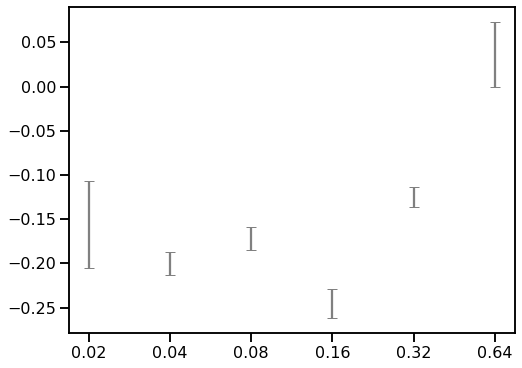

In [219]:
fig, axx = plt.subplots(figsize=(8, 6))
axx.errorbar(np.arange(adp_pref_agg.shape[0]), adp_pref_agg,
            yerr=adp_pref_sem, fmt='none', color='gray', capsize=5)
axx.set_xticklabels(['0','0.02', '0.04', '0.08', '0.16', '0.32', '0.64']);

### one way anova

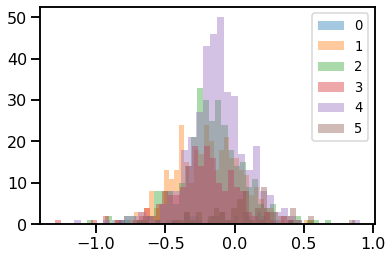

In [187]:
# test assumption of normality: looks maybe normal, need Shapiro-Wilk test

df_adp_pref_dropna = df_adp_pref.dropna(subset=['adp_pref'])
gb = df_adp_pref_dropna.groupby('stim_id')
adp_SF = []
for stim_id, group in gb:
    # print(stim_id)
    # print(group)
    # print(group['adp_pref'].values[:5])
    adp_iSF = group['adp_pref'].values
    adp_SF.append(adp_iSF)
    plt.hist(adp_iSF, bins=40, alpha=0.4, label=stim_id)
plt.legend();

In [188]:
# test assumption of equal variance: looks not equal, need Levene test, bartlett test, or fligner-killeen test
# "ANOVA is robust to heterogeneity of variance so long as the largest variance is not more than 4 times the smallest variance. general effect of heterogeneity of variance is to make the ANOVA less efficient. That is, you would have lower power" - https://stats.stackexchange.com/questions/56971/alternative-to-one-way-anova-unequal-variance
adp_SF_var = [np.var(adp_iSF) for adp_iSF in adp_SF]
adp_SF_var

# test assumption of independence: no idea

[0.09843194929625051,
 0.056494888286521106,
 0.055851170494090656,
 0.059882341541445,
 0.05017926439477372,
 0.09762800337045476]

In [189]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

df_adp_pref_dropna = df_adp_pref.dropna()

# perform one-way ANOVA
import scipy.stats as stats
stats.f_oneway(df_adp_pref_dropna[df_adp_pref_dropna['stim_id']==0]['adp_pref'].values,
                df_adp_pref_dropna[df_adp_pref_dropna['stim_id']==1]['adp_pref'].values,
                df_adp_pref_dropna[df_adp_pref_dropna['stim_id']==2]['adp_pref'].values,
                df_adp_pref_dropna[df_adp_pref_dropna['stim_id']==3]['adp_pref'].values,
                df_adp_pref_dropna[df_adp_pref_dropna['stim_id']==4]['adp_pref'].values,
                # df_adp_pref_dropna[df_adp_pref_dropna['stim_id']==5]['adp_pref'].values, # last stim_id has only 1 cell
                )

F_onewayResult(statistic=7.205911357620242, pvalue=9.781578066668933e-06)

### boxplot across boots
for each SF, take cells that prefer this grating SF. boxplot errorbar is across boots (already averaged across cells)

In [604]:
# output should be of shape: nboot x nstim x ncell
# for each bootstrap, for each stim x cell, randomly select nrep trials

nboot = 2000
nrep_selected = 30

adp_boot_pop = []
for iboot in tqdm(np.arange(nboot)):
    R1_agg = (df_pref[(df_pref['resp_id']=='R1')]
                .groupby(['stim_id', 'cell_id'])['dfof']
                .apply(lambda x: x.sample(n=nrep_selected, replace=True).sum())
                .to_frame().reset_index()
                .groupby(['stim_id'])['dfof'] # sum over cells preferring each stim
                .sum().values
                )
    R2_agg = (df_pref[(df_pref['resp_id']=='R1')]
                .groupby(['stim_id', 'cell_id'])['dfof']
                .apply(lambda x: x.sample(n=nrep_selected, replace=True).sum())
                .to_frame().reset_index()
                .groupby(['stim_id'])['dfof']
                .sum().values
                )
    adp_agg = (R2_agg - R1_agg) / (R1_agg + 1e-7)
    adp_agg[np.abs(adp_agg) > 5] = np.nan # remove outliers
    adp_boot_pop.append(adp_agg)
print('adp hard thresholding')

adp_boot_pop = np.array(adp_boot_pop)
adp_boot_pop.shape # nboot x nstim

100%|██████████| 2000/2000 [20:11<00:00,  1.65it/s]

adp hard thresholding


(2000, 6)

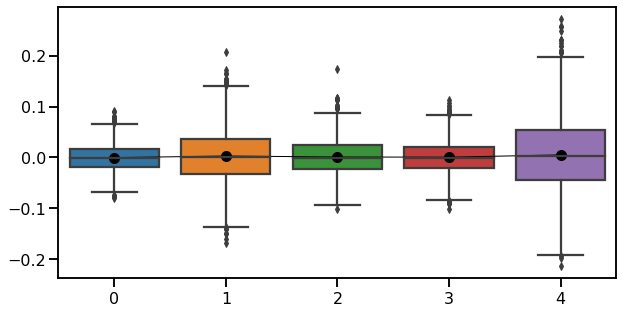

In [606]:
# df_adp_pref_pop = pd.DataFrame(adp_boot_pop, columns=df_adp_pref.stim_id.unique()) # only works if all stim_id survived adp thres
df_adp_pref_pop = pd.DataFrame(adp_boot_pop, columns=np.arange(0, 6)) # pretend that all stim_id survived adp thres
df_adp_pref_pop = df_adp_pref_pop.drop(columns=5) # drop column 5 due to ncell=1
# df_adp_pref_pop

fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=df_adp_pref_pop, ax=ax)
ax.plot(df_adp_pref_pop.mean().values, 'k', marker='o', markersize=10, linewidth=1)

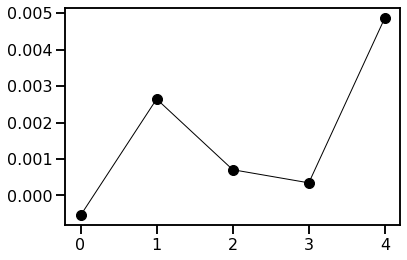

In [609]:
plt.plot(df_adp_pref_pop.mean().values, 'k', marker='o', markersize=10, linewidth=1)

# trial filter impact on adp stability
## using new grat1
copied from grat1_mix50.ipynb  
TODO: refactor

In [74]:
dir_csv = r'Z:\All_Staff\home\lan\Data\2P_images\mat_inter\V1_i1380_230207_cellpose'.replace('\\', '/')
filename = 'df_tidy.csv'
df_tidy = pd.read_csv(os.path.join(dir_csv, filename))
trial_ok = df_tidy.groupby('trial_id').mean()['filter_trial'].astype(bool).values

mouse = 1380
date = 230207
dir_data = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter/'
dir_data += f'V1_i{mouse}_{date}_cellpose'
stim_id, trace_by_trial = adp.load_trace_trial_data(os.path.join(dir_data), vis_filter=False)

# get resp_ad and resp_tg [cell x trial]
base1 = trace_by_trial[:,:,0:2+1].mean(axis=2) # avg over time window frames
resp_ad = trace_by_trial[:,:,9:11+1].mean(axis=2)
resp_ad = resp_ad - base1
base2 = trace_by_trial[:,:,13:14+1].mean(axis=2)
resp_tg = trace_by_trial[:,:,20:22+1].mean(axis=2)
resp_tg = resp_tg - base2
resp_ad.shape, resp_tg.shape

ncell: 135, nstim: 1, ntrial: 1257, nframe: 257


((135, 1257), (135, 1257))

In [75]:
trace_by_trial_ori = trace_by_trial.copy()
stim_id_ori = stim_id.copy()
resp_ad_ori = resp_ad.copy()
resp_tg_ori = resp_tg.copy()

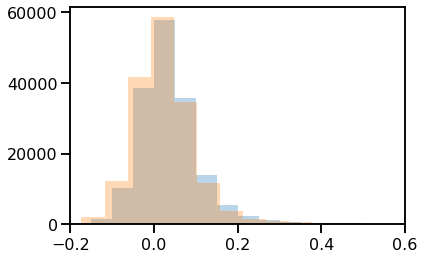

In [76]:
plt.hist(resp_ad.ravel(), bins=100, alpha=0.3, label='AD');
plt.hist(resp_tg.ravel(), bins=100, alpha=0.3, label='TG');
plt.xlim(-0.2, 0.6);

# trace_by_trial.shape, stim_id.shape, resp_ad.shape, resp_tg.shape, trial_ok.shape

## strictness of trial filter
with increasingly strict cutoff of eye mov dist

In [7]:
trial_filter_file = [f for f in os.listdir(dir_data) if f.__contains__('filter_trials_')]
eye_mov = np.array([])
for file in trial_filter_file:
    trial_filter = sio.loadmat(os.path.join(dir_data, file))
    # print(trial_filter.keys())
    # break
    # eye_mov_sess = trial_filter['eye_move_dist'][:-1, :] # remove the last trial, which is not a full trial
    eye_mov_sess = trial_filter['pupil_deviation'][:, :-1].T
    eye_mov = np.append(eye_mov, eye_mov_sess)

eye_mov = np.array(eye_mov)
assert len(trial_ok) == len(eye_mov)

[ 2.18  2.83  3.49  4.13  4.86  5.73  7.13  9.04 32.19]


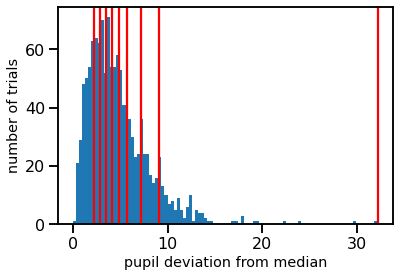

In [8]:
eye_mov_perc = np.percentile(eye_mov, 100), np.percentile(eye_mov, 90), np.percentile(eye_mov, 80), np.percentile(eye_mov, 70), np.percentile(eye_mov, 60), \
np.percentile(eye_mov, 50), np.percentile(eye_mov, 40), np.percentile(eye_mov, 30), np.percentile(eye_mov, 20), # np.percentile(eye_mov, 10)
eye_mov_perc = np.array(eye_mov_perc[::-1])
print(np.round(eye_mov_perc, 2))

# plt.plot(eye_mov_perc, 'k', marker='o', markersize=10, linewidth=1)
# plt.xlabel('percentile')
# plt.ylabel('eye movement distance');

plt.hist(eye_mov, bins=100)
for i in range(len(eye_mov_perc)):
    plt.axvline(eye_mov_perc[i], color='r', linestyle='-')
# plt.xscale('log')
# plt.xlim(0, 10);
plt.xlabel('pupil deviation from median')
plt.ylabel('number of trials');

cutoff: 2.2, ntrial: 255
cutoff: 2.8, ntrial: 373
cutoff: 3.5, ntrial: 504
cutoff: 4.1, ntrial: 622
cutoff: 4.9, ntrial: 762
cutoff: 5.7, ntrial: 876
cutoff: 7.1, ntrial: 1002
cutoff: 9.0, ntrial: 1129
cutoff: 32.2, ntrial: 1257


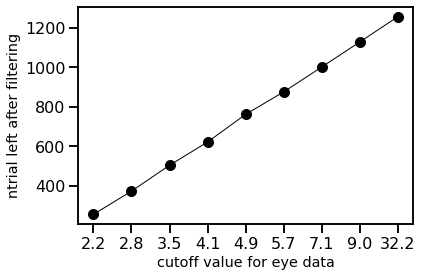

In [9]:
eye_mov_perc = np.round(eye_mov_perc, 1)
trial_ok_cutoff_arr = []
for cutoff in eye_mov_perc:
    trial_ok_cutoff = eye_mov < cutoff # trials with eye movement less than cutoff are good
    trial_ok_cutoff_arr.append(trial_ok_cutoff)
    print(f'cutoff: {cutoff:.1f}, ntrial: {trial_ok_cutoff.sum()}')
trial_ok_cutoff_arr = np.array(trial_ok_cutoff_arr)

plt.plot(trial_ok_cutoff_arr.sum(axis=1), 'k', marker='o', markersize=10, linewidth=1)
plt.xlabel('cutoff value for eye data')
plt.xticks(np.arange(0, 9), np.round(eye_mov_perc, 1));
plt.ylabel('ntrial left after filtering');

In [31]:
def get_adp_stability(trace_by_trial, stim_id, resp_ad, resp_tg, mode='adp'):
    # mean_or_median = np.median # for population, median is better than mean
    mean_or_median = np.median
    resp_ad_pop = mean_or_median(resp_ad, axis=0) # population response as avg or median of all cells for each trial
    resp_tg_pop = mean_or_median(resp_tg, axis=0)

    # shuffle resp_ad_pop and resp_tg_pop the same way
    np.random.seed(42)
    idx = np.random.permutation(resp_ad_pop.shape[0])
    resp_ad_pop_shuf = resp_ad_pop[idx]
    resp_tg_pop_shuf = resp_tg_pop[idx]

    # for whole population, loop thru trial numbers to group together to get a stable adaptation value  
    adp_agg = []
    adp_std = []
    for group_size in np.arange(1, trace_by_trial.shape[1] // 5): # >= n groups of trials
        ngroup = trace_by_trial.shape[1] // group_size

        resp_ad_cut = resp_ad_pop_shuf[:group_size*ngroup].reshape(ngroup, group_size) # reshape to ngroup x group_size
        resp_tg_cut = resp_tg_pop_shuf[:group_size*ngroup].reshape(ngroup, group_size)
        resp_ad_group = mean_or_median(resp_ad_cut, axis=1) # aggregate resp within group of trials
        resp_tg_group = mean_or_median(resp_tg_cut, axis=1)

        adp_group = (resp_tg_group - resp_ad_group) / (resp_tg_group + resp_ad_group + 1e-7) # calc adp with `avg resp within group`
        if mode == 'R1':
            adp_group = resp_ad_group
        adp_group_agg = mean_or_median(adp_group) # agg adp across group
        adp_group_std = np.std(adp_group) # std of adp across group
        adp_agg.append(adp_group_agg) # group_size variable, all cell resp agg
        adp_std.append(adp_group_std)

    adp_agg = np.array(adp_agg)
    adp_std = np.array(adp_std)
    adp_sem = adp_std / np.sqrt(adp_std.shape[0])

    # for each cell, same as above
    ncell = trace_by_trial.shape[0]
    ngroup_min = 2
    nsize = len(np.arange(1, trace_by_trial.shape[1] // ngroup_min)) # how many group_size to test
    adp_cell_agg = np.zeros((ncell, nsize))
    adp_cell_std = np.zeros((ncell, nsize))
    adp_cell_sem = np.zeros((ncell, nsize))

    for icell in np.arange(ncell):
        resp_ad_cell = resp_ad[icell, :]
        resp_tg_cell = resp_tg[icell, :]

        # shuffle resp_ad_pop and resp_tg_pop the same way
        np.random.seed(42)
        idx = np.random.permutation(resp_ad_pop.shape[0])
        resp_ad_cell_shuf = resp_ad_cell[idx]
        resp_tg_cell_shuf = resp_tg_cell[idx]

        for isize, group_size in enumerate(np.arange(1, trace_by_trial.shape[1] // ngroup_min)):
            ngroup = trace_by_trial.shape[1] // group_size

            resp_ad_cut = resp_ad_cell_shuf[:group_size*ngroup].reshape(ngroup, group_size)
            resp_tg_cut = resp_tg_cell_shuf[:group_size*ngroup].reshape(ngroup, group_size)
            resp_ad_group = mean_or_median(resp_ad_cut, axis=1)
            resp_tg_group = mean_or_median(resp_tg_cut, axis=1)

            adp_group = (resp_tg_group - resp_ad_group) / (resp_tg_group + resp_ad_group + 1e-7)
            if mode == 'R1':
                adp_group = resp_ad_group
            adp_group_agg = mean_or_median(adp_group)
            adp_group_std = np.std(adp_group)
            adp_group_sem = adp_group_std / np.sqrt(adp_group.shape[0])
            adp_cell_agg[icell, isize] = adp_group_agg
            adp_cell_std[icell, isize] = adp_group_std
            adp_cell_sem[icell, isize] = adp_group_sem

    adp_cell_agg_agg = mean_or_median(adp_cell_agg, axis=0)
    adp_cell_std_agg = mean_or_median(adp_cell_std, axis=0)
    adp_cell_sem_agg = mean_or_median(adp_cell_sem, axis=0) # adp error between groups -> agg across cells

    return adp_cell_agg_agg, adp_cell_sem_agg, adp_cell_std_agg, adp_agg, adp_sem, adp_std

In [39]:
def plot_adp_stability(adp_cell_agg_agg, adp_cell_sem_agg, adp_agg, adp_sem, ax_id, xlim_bool=True, err_only=False, colors=['blue', 'red'], mode='adp'):

    if err_only == False:
        x = np.arange(1, adp_cell_agg_agg.shape[0]+1)
        ax_id.plot(x, adp_cell_agg_agg, '-', color='blue', linewidth=3, alpha=0.7, label='single neurons')
        ax_id.fill_between(x,  
                        adp_cell_agg_agg + adp_cell_sem_agg, adp_cell_agg_agg - adp_cell_sem_agg, color='b', alpha=0.2)

        x = np.arange(1, adp_agg.shape[0]+1)
        ax_id.plot(x, adp_agg, '-', color='red', linewidth=3, alpha=0.3, label='population')
        ax_id.fill_between(x, 
                        adp_agg + adp_sem, adp_agg - adp_sem, 
                        color='r', alpha=0.2)
        # ax_id.set_ylim(-1, 0)
        ax_id.axhline(0, color='k', linewidth=1, linestyle='--')

    elif err_only: # only plot error
        x = np.arange(1, adp_cell_agg_agg.shape[0]+1)
        ax_id.plot(x, adp_cell_sem_agg, '-', color=colors[0], linewidth=3, alpha=0.7, label='single neurons')

        x = np.arange(1, adp_agg.shape[0]+1)
        ax_id.plot(x, adp_sem, '-', color=colors[1], linewidth=3, alpha=0.5, label='population')
        ax_id.set_ylim(0, 1) # mean_or_median = median
        # ax_id.set_ylim(0, 10) # mean_or_median = mean
        if mode == 'R1':
            ax_id.set_ylim(0, 0.1)
        ax_id.axhline(0.1, color='k', linewidth=1, linestyle='--')

    # text at bottom right
    ax_id.text(0.95, 0.95, f'cutoff = {eye_mov_perc[i]}',
            verticalalignment='top', horizontalalignment='right',
            transform=ax_id.transAxes,
            color='blue', fontsize=14)

    if xlim_bool:
        ax_id.set_xlim(0, 40)

### adp err only

In [45]:
ncutoff = trial_ok_cutoff_arr.shape[0] # trial_ok_cutoff_arr.shape = ncutoff, ntrial
adp_cell_cutoff = []
adp_cell_sem_cutoff = []
adp_pop_cutoff = []
adp_pop_sem_cutoff = []

for i in tqdm(range(ncutoff)):
    trial_ok = trial_ok_cutoff_arr[i, :]
    trace_by_trial = trace_by_trial_ori[:, trial_ok, :]
    stim_id = stim_id_ori[0][trial_ok]
    resp_ad = resp_ad_ori[:, trial_ok]
    resp_tg = resp_tg_ori[:, trial_ok]

    adp_cell_agg_agg, adp_cell_sem_agg, adp_cell_std_agg, adp_agg, adp_sem, adp_std = get_adp_stability(trace_by_trial, stim_id, resp_ad, resp_tg)
    adp_cell_cutoff.append(adp_cell_agg_agg)
    adp_cell_sem_cutoff.append(adp_cell_sem_agg)
    adp_pop_cutoff.append(adp_agg)
    adp_pop_sem_cutoff.append(adp_sem)

adp_cell_cutoff.__len__(), adp_cell_cutoff[0].shape, adp_cell_cutoff[1].shape, 

100%|██████████| 9/9 [01:10<00:00,  7.88s/it]


(9, (126,), (185,))

use median to aggregate across trials (for grouped adaptation index) and cells (for population response) yields higher adp stability. but essentially the same result as np.mean: we take 30 trials to aggregate for single cell adp, and 10 trials for population adp.


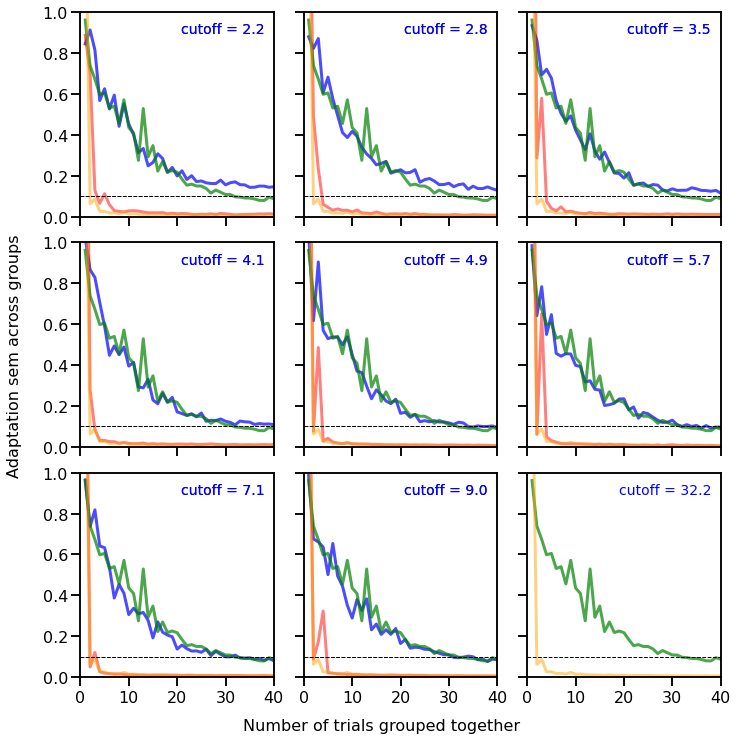

In [46]:
f, ax = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(10, 10)) # 3x3 subplots for 9 cutoffs
f.text(0.5, -0.02, 'Number of trials grouped together', ha='center', fontsize=16)
f.text(-0.02, 0.5, 'Adaptation sem across groups', va='center', rotation='vertical', fontsize=16)

for i in (range(ncutoff-1)):
    adp_cell_agg_agg = adp_cell_cutoff[i]
    adp_cell_sem_agg = adp_cell_sem_cutoff[i]
    adp_agg = adp_pop_cutoff[i]
    adp_sem = adp_pop_sem_cutoff[i]
    plot_adp_stability(adp_cell_agg_agg, adp_cell_sem_agg, adp_agg, adp_sem, ax[i//3, i%3], xlim_bool=True, err_only=True)

for i in (range(ncutoff)):
    plot_adp_stability(adp_cell_cutoff[-1], adp_cell_sem_cutoff[-1], adp_pop_cutoff[-1], adp_pop_sem_cutoff[-1], ax[i//3, i%3], xlim_bool=True, err_only=True, colors=['green', 'orange'])

f.tight_layout()

print('use median to aggregate across trials (for grouped adaptation index) and cells (for population response) yields higher adp stability. but essentially the same result as np.mean: we take 30 trials to aggregate for single cell adp, and 10 trials for population adp.')

### R1 err

In [34]:
adp_cell_cutoff = []
adp_cell_err_cutoff = []
adp_pop_cutoff = []
adp_pop_err_cutoff = []

for i in tqdm(range(ncutoff)):
    trial_ok = trial_ok_cutoff_arr[i, :]
    trace_by_trial = trace_by_trial_ori[:, trial_ok, :]
    stim_id = stim_id_ori[0][trial_ok]
    resp_ad = resp_ad_ori[:, trial_ok]
    resp_tg = resp_tg_ori[:, trial_ok]

    adp_cell_agg_agg, adp_cell_sem_agg, adp_cell_std_agg, adp_agg, adp_sem, adp_std = get_adp_stability(trace_by_trial, stim_id, resp_ad, resp_tg, mode='R1')
    adp_cell_cutoff.append(adp_cell_agg_agg)
    adp_cell_err_cutoff.append(adp_cell_std_agg)
    adp_pop_cutoff.append(adp_agg)
    adp_pop_err_cutoff.append(adp_std)

adp_cell_cutoff.__len__(), adp_cell_cutoff[0].shape, adp_cell_cutoff[1].shape, 

100%|██████████| 9/9 [01:10<00:00,  7.85s/it]


(9, (126,), (185,))

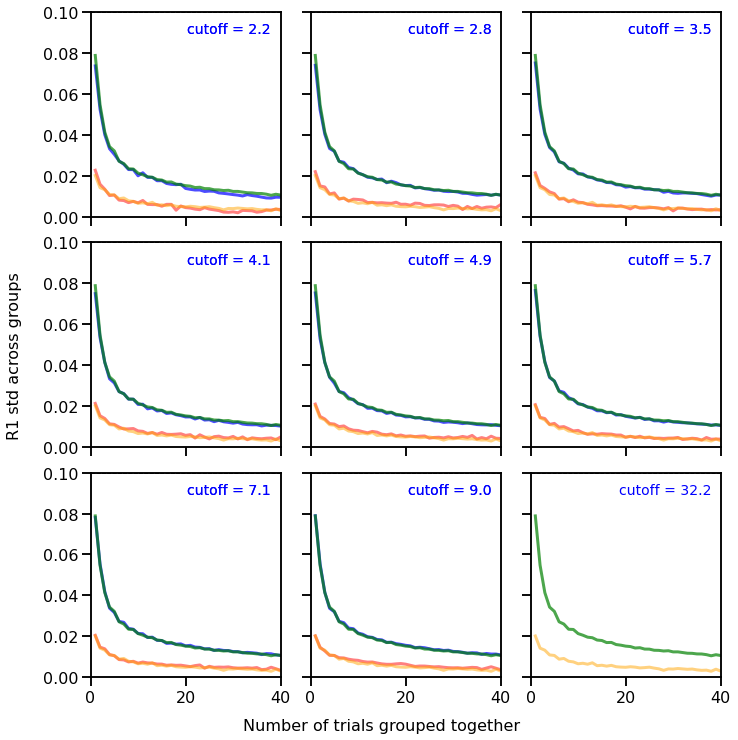

In [43]:
f, ax = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(10, 10)) # 3x3 subplots for 9 cutoffs
f.text(0.5, -0.02, 'Number of trials grouped together', ha='center', fontsize=16)
f.text(-0.02, 0.5, 'R1 std across groups', va='center', rotation='vertical', fontsize=16)

for i in (range(ncutoff-1)):
    adp_cell_agg_agg = adp_cell_cutoff[i]
    adp_cell_err_agg = adp_cell_err_cutoff[i]
    adp_agg = adp_pop_cutoff[i]
    adp_err = adp_pop_err_cutoff[i]
    plot_adp_stability(adp_cell_agg_agg, adp_cell_err_agg, adp_agg, adp_err, ax[i//3, i%3], xlim_bool=True, err_only=True, mode='R1')

for i in (range(ncutoff)):
    plot_adp_stability(adp_cell_cutoff[-1], adp_cell_err_cutoff[-1], adp_pop_cutoff[-1], adp_pop_err_cutoff[-1], ax[i//3, i%3], xlim_bool=True, err_only=True, colors=['green', 'orange'], mode='R1')

f.tight_layout()

In [ ]:
# looks like the less we cut off (by eye movement distance or by pupil deviation from median), the more stable the adaptation index is

## adp stability over boots
not over groups of trials

In [77]:
# filter df_tidy
df_filter = df_tidy[df_tidy['filter_cell'] # vis driven filter
                    # & df_tidy['filter_cell_stim'] # img driven filter
                    # & df_tidy['filter_trial']
                    ]
df_filter                    

,dfof,cell_id,trial_id,stim_id,resp_id,filter_trial,filter_cell,filter_cell_stim
1257,-0.044027,1,0,0,R1,False,True,True
1258,0.049366,1,1,0,R1,True,True,True
1259,0.043668,1,2,0,R1,True,True,True
1260,0.073826,1,3,0,R1,True,True,True
1261,0.053160,1,4,0,R1,True,True,True
...,...,...,...,...,...,...,...,...
335614,-0.032953,131,1252,0,R2,True,True,True
335615,0.061504,131,1253,0,R2,False,True,True
335616,0.028452,131,1254,0,R2,False,True,True
335617,0.030008,131,1255,0,R2,False,True,True


### population

In [88]:
nboot = 100
nrep_arr = [2, 3, 5, 10, 20, 30, 50, 100, 200, 300] # possible number of trials to group together
adp_boot_rep = []

for nrep_selected in tqdm(nrep_arr):
    seed_arr = np.random.randint(0, 100, size=nboot) # get random seed for each bootstrap
    adp_boot = []
    for iboot in (np.arange(nboot)):
        
        df_R1 = df_filter[(df_filter['resp_id']=='R1')].copy() # length of df_R1 = ncell x ntrial
        pop_R1_trials = df_R1.groupby(['trial_id']).dfof.sum() # pop resp of each trial in R1
        R1_agg = pop_R1_trials.sample(n=nrep_selected, replace=True, 
                                      random_state=seed_arr[iboot]).values.sum() # sum over nrep_selected trials

        df_R2 = df_filter[(df_filter['resp_id']=='R2')].copy()
        pop_R2_trials = df_R2.groupby(['trial_id']).dfof.sum()
        R2_agg = pop_R2_trials.sample(n=nrep_selected, replace=True,
                                      random_state=seed_arr[iboot]).values.sum()

        adp_agg = (R2_agg - R1_agg) / (R2_agg + R1_agg + 1e-7)
        adp_boot.append(adp_agg)
    adp_boot_rep.append(adp_boot)

adp_boot_rep = np.array(adp_boot_rep)
adp_boot_rep.shape # n(possible rep_selected) x nboot

100%|██████████| 10/10 [00:18<00:00,  1.90s/it]


(10, 100)

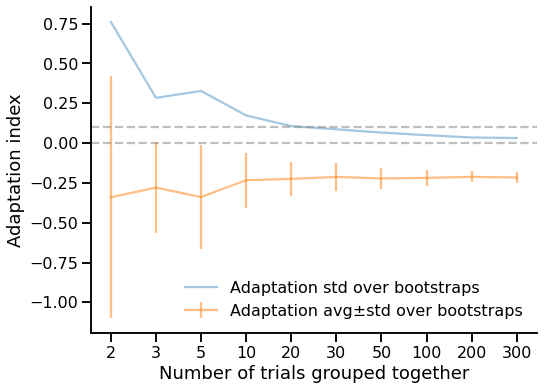

In [92]:
adp_boot_rep[np.abs(adp_boot_rep) > 5] = np.nan # remove outliers
adp_rep = np.nanmean(adp_boot_rep, axis=1) # n(possible nrep selected) x ncell
adp_rep_std = np.nanstd(adp_boot_rep, axis=1) 

f, ax = plt.subplots(1, 1, figsize=(8,6))
ax.plot(adp_rep_std, alpha=0.4, label='Adaptation std over bootstraps')
ax.errorbar(np.arange(len(nrep_arr)), adp_rep, yerr=adp_rep_std, alpha=0.5, 
            label='Adaptation avg±std over bootstraps') # avg adp over boot, across different nrep_selected
ax.axhline(0.1, color='gray', linestyle='--', alpha=0.5)
ax.axhline(0., color='gray', linestyle='--', alpha=0.5)

ax.legend(fontsize=16, frameon=False, loc='lower right')
ax.set_xticks(np.arange(len(nrep_arr)))
ax.set_xticklabels(nrep_arr)
ax.set_xlabel('Number of trials grouped together', fontsize=18)
ax.set_ylabel('Adaptation index', fontsize=18);

# turn off top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False);

dir_fig = r'C:\Users\ll357\Documents\inter\results\joint lab meeting 2023-03'.replace('\\', '/')
f.savefig(os.path.join(dir_fig, 'adp_stability_pop_boot.pdf'), bbox_inches='tight')

### single cell

In [93]:
# for each bootstrap, for each cell, randomly select nrep trials

nboot = 100
nrep_arr = [5, 10, 20, 30, 50, 100, 150, 200, 300] # possible number of trials to group together
adp_boot_rep = []
for nrep_selected in tqdm(nrep_arr):
    seed_arr = np.random.randint(0, 100, size=nboot) # get random seed for each bootstrap
    adp_boot = []
    for iboot in (np.arange(nboot)):
        R1_agg = (df_filter[(df_filter['resp_id']=='R1')]
                        .groupby(['cell_id'])
                        ['dfof']
                        .apply(lambda x: x.sample(n=nrep_selected, replace=True,
                                                  random_state=seed_arr[iboot]).sum())
                        .reset_index()['dfof'].values) # for each stim x cell, randomly select nrep trials resp, take sum
        R2_agg = (df_filter[(df_filter['resp_id']=='R2')]
                        .groupby(['cell_id'])
                        ['dfof']
                        .apply(lambda x: x.sample(n=nrep_selected, replace=True,
                                                  random_state=seed_arr[iboot]).sum())
                        .reset_index()['dfof'].values)
        adp_agg = (R2_agg - R1_agg) / (R2_agg + R1_agg + 1e-7)
        adp_agg[np.abs(adp_agg) > 5] = np.nan # remove outliers
        adp_boot.append(adp_agg)
    adp_boot_rep.append(adp_boot)

adp_boot_rep = np.array(adp_boot_rep)
adp_boot_rep.shape # n(possible rep_selected) x nboot x ncell

100%|██████████| 9/9 [00:39<00:00,  4.38s/it]


(9, 100, 38)

In [107]:
adp_rep.shape[1] # ncell

38

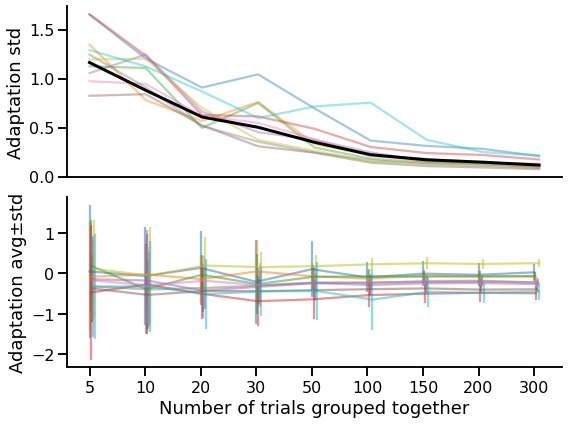

In [106]:
adp_rep = np.nanmean(adp_boot_rep, axis=1) # n(possible nrep selected) x ncell
adp_rep_std = np.nanstd(adp_boot_rep, axis=1) 

# for each cell, plot adp_rep and std across nboot
f, ax = plt.subplots(2, 1, figsize=(8, 6),)
for i in (np.arange(10)): # adp_rep.shape[1]
    ax[0,].plot(adp_rep_std[:, i], alpha=0.4)
    ax[1,].errorbar(np.arange(len(nrep_arr)) + 0.01*i, adp_rep[:, i], yerr=adp_rep_std[:, i], alpha=0.5) # avg adp over boot, across different nrep_selected
    
ax[0].plot(np.nanmean(adp_rep_std, axis=1), color='black', linewidth=3)
ax[0].set_xticks([]) # turn off xticks
ax[1].set_xticks(np.arange(len(nrep_arr)))
ax[1].set_xticklabels(nrep_arr)
ax[1].set_xlabel('Number of trials grouped together', fontsize=18)
ax[0].set_ylabel('Adaptation std', fontsize=18);
ax[1].set_ylabel('Adaptation avg±std', fontsize=18);

# turn off top and right spines
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False);
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False);
f.tight_layout()

dir_fig = r'C:\Users\ll357\Documents\inter\results\joint lab meeting 2023-03'.replace('\\', '/')
f.savefig(os.path.join(dir_fig, 'adp_stability_single_cell_boot.pdf'), bbox_inches='tight')